In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import imp
import collections
import scipy.stats as stats
twto = imp.load_source('twto','/cellar/users/twang/scripts/twang_toolbox.py')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline
import itertools
import subprocess
#import h5py

In [2]:
sns.set(context='notebook',style='whitegrid')

## Overview

This set of analyses characterizes the methylation at the ELOLV2 promoter region. The samples that are used are from three studies and all mice are normal. These studies were chosen for being liver and have sampled >2 time points:
<br>
<br>
-SRP073930, whole blood Petkovich et al. 2016<br>
-SRP097629, liver Stubbs et al. 2016 <br>
-PRJNA257275, liver Reizel et al. 2016 <br>
<br>
<br>
Sites with >5 reads were used in this analysis so that we could look at all CpGs at that locus. Missing CpGs were imputed within tissue using k-nearest neighbors methods.

#### Loading  datasets 

In [5]:
hdf_files = twto.make_files_tuple('Dorota/','.h5')
df_dict_by_study = {}

for fname,fpath in hdf_files:
    
    df_dict = {key:pd.read_hdf(fpath, key) for key in ['reads','methy_mat','covs']}
    study = fname.split('_')[0]
    if study in ['SRP073930','SRP097629','PRJNA257275']:
        df_dict_by_study[study] = df_dict
    
    
outf = 'Dorota/190417_PearsonCorrelationPerSiteStudy.txt'
cat_pearcorr = pd.read_csv(outf, sep = '\t',header = 0, index_col = None)
cat_pearcorr = cat_pearcorr.dropna()

overlapallsites = [set(df_dict_by_study[x]['methy_mat'].columns) for x in ['PRJNA257275','SRP073930']]
overlaprrbsuse = list(set.intersection(*overlapallsites))

cat_pearcorr_use = cat_pearcorr[cat_pearcorr['index'].isin(overlaprrbsuse)].copy(deep=True)

outf = 'Dorota/190417_LiverBloodCoveredCpGs.txt'
catplt = pd.read_csv(outf, sep = '\t',header = 0, index_col = None)

map_study_to_tissue = {'PRJNA257275':'liver','SRP097629':'liver','SRP073930':'blood'}

## Dataset characteristics

These following plots are to give you an idea of the age distribution and the number of samples that are present. Only Reizel has two genders (25M vs 24F), and there is an equal number of male and females, in the other two studies, there are only males

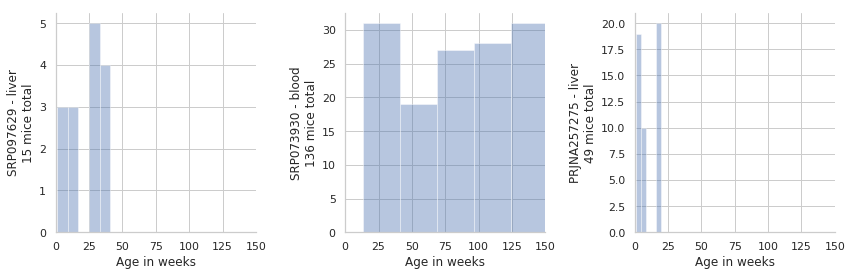

In [6]:
covariates_by_study = {s:df_dict_by_study[s]['covs'] for s in df_dict_by_study.keys()}

f, axes = plt.subplots(1,3, figsize = (12,4))
##Age
#axes = axesall[0]
for i,study in enumerate(covariates_by_study):
    
    covs = covariates_by_study[study] 
    #print(covs['gender'].value_counts())
    tissue = map_study_to_tissue[study]
    covs['Study'] = study
    total_mice = covs.shape[0]
    ax = sns.distplot(covs['age_days']/7, ax = axes[i], kde = False, bins = 5)
    #ax.legend(loc='upper right')
    ax.set_xlabel('Age in weeks')
    ax.set_ylabel('{} - {}\n{} mice total'.format(study,tissue, total_mice))
    ax.set_xlim([0,150])
    covariates_by_study[study] = covs

f.tight_layout()
sns.despine()
plt.show()
plt.close()

concatcovs = pd.concat(covariates_by_study.values(),sort=False)[['age_days','gender','Study','tissue']]
concatcovs['Ageweeks'] = concatcovs['age_days']/7
concatcovs['AgeBin'] = pd.cut(concatcovs['age_days'], 6, labels = False)

catplt['ageBin'] = catplt['index'].map(concatcovs['AgeBin'])
catplt['tissue'] = catplt['index'].map(concatcovs['tissue'])
catplt['AgeWeek'] = catplt['age_days']/7

It is important to note that the blood mice are all much older than the mice used in liver.

This plot shows the average methylation of all CpGs profiled in the ELOLV2 promoter region (relative to the start site), without stratifying for age.

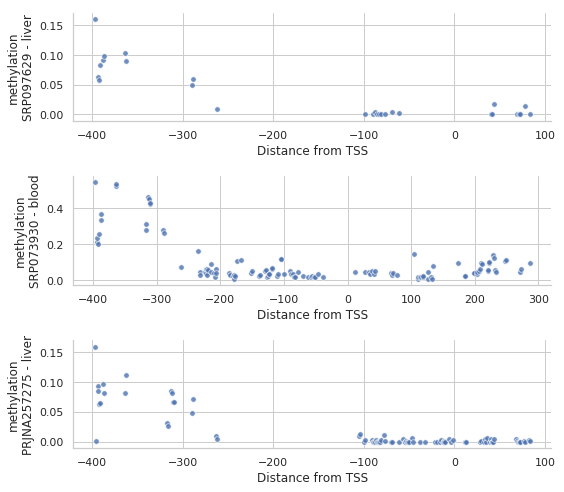

In [7]:
methmat_by_study = {s:df_dict_by_study[s]['methy_mat'].reset_index().melt(id_vars='index') for s in df_dict_by_study.keys()}

TSS = 41220405

cat_methy_mats = []

f, axes = plt.subplots(3,1, figsize = (8,7))
for i,study in enumerate(methmat_by_study):
    
    methy_dfm = methmat_by_study[study]
    methy_dfm['c'] = [(int(x.split(':')[-1])-TSS)*-1 for x in methy_dfm['variable']]
    methy_dfm_avrg = methy_dfm.groupby('c').apply(lambda x: x['value'].mean()).reset_index()
    ax = sns.scatterplot(x='c',y=0, data = methy_dfm_avrg, ax = axes[i], s = 30, alpha = 0.8)
    #ax.legend(loc='upper right')
    ax.set_xlabel('Distance from TSS')
    ax.set_ylabel('methylation\n{} - {}'.format(study,map_study_to_tissue[study]))
    methy_dfm['Study'] = study
    cat_methy_mats.append(methy_dfm)
    #ax.set_ylim([-0.1,0.8])

f.tight_layout()
sns.despine()
plt.show()
plt.close()

cat_methy_mats = pd.concat(cat_methy_mats).reset_index(drop=True)

For all tissues, the region that is 300-400bp upstream of the TSS has much higher methylation levels relative to other regions. When comparing across tissues liver has much lower levels of methylation overall.

We will next study the effect of age in the region 300-400bp upstream of the liver by averaging mice into 6 agebins across all mice. Just to give you an idea of what this looks like....

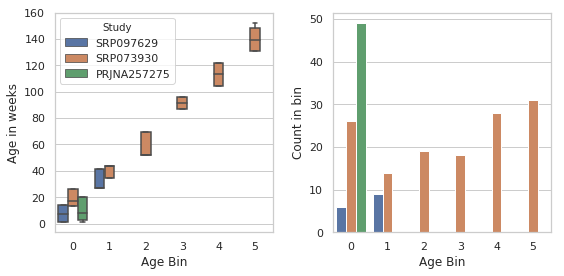

In [8]:
f,axes = plt.subplots(1,2,figsize=(8,4))

ax = sns.boxplot(x='AgeBin', y = 'Ageweeks', hue='Study',data=concatcovs, ax = axes[0])
ax.set_xlabel('Age Bin')
ax.set_ylabel('Age in weeks')

ax = sns.countplot(x='AgeBin', hue='Study',data=concatcovs, ax = axes[1])
ax.set_xlabel('Age Bin')
ax.set_ylabel('Count in bin')
ax.legend('',frameon=False)

f.tight_layout()
plt.show()
plt.close()

Now looking at age where we separate by tissue for illustrative purposes with multiple bins...

In [9]:
cat_methy_mats['AgeBin'] = cat_methy_mats['index'].map(concatcovs['AgeBin'])

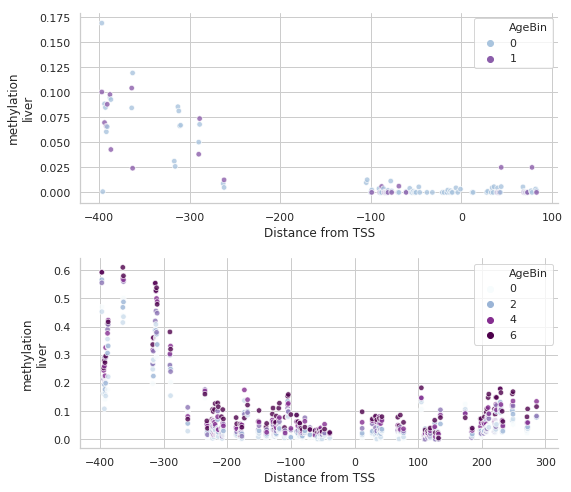

In [10]:
f, axes = plt.subplots(2,1, figsize = (8,7))
keys2use = [['SRP097629','PRJNA257275'],['SRP073930']]
for i,studygrp in enumerate(keys2use):
    
    methy_dfm = cat_methy_mats[cat_methy_mats['Study'].isin(studygrp)]
    methy_dfm_avrg = methy_dfm.groupby(['c','AgeBin']).apply(lambda x: x['value'].mean()).reset_index()
    ax = sns.scatterplot(x='c',y=0,hue='AgeBin', data = methy_dfm_avrg, ax = axes[i], s = 30, alpha = 0.8,
                        palette='BuPu')
    ax.legend(loc='upper right')
    ax.set_xlabel('Distance from TSS')
    ax.set_ylabel('methylation\n{}'.format(tissue))
    methmat_by_study[study] = methy_dfm
    #ax.set_ylim([-0.1,0.8])

f.tight_layout()
sns.despine()
plt.show()
plt.close()


By age, the blood shows a much more obvious increase in methylation signal than liver.

## We can look at the correlation of each CpG against age for each study

In [11]:
cat_pearcorr_use['tissue'] = cat_pearcorr_use['Study'].map(map_study_to_tissue)

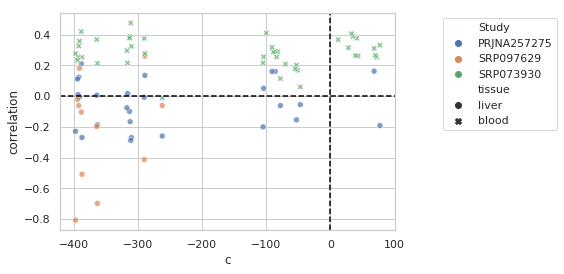

In [12]:
ax = sns.scatterplot(x='c',y='correlation',hue='Study',style='tissue',data = cat_pearcorr_use,alpha=0.7)
ax.legend(bbox_to_anchor = (1.5,1))
ax.axhline(0,ls='--',color='black')
ax.axvline(0,ls='--',color='black')
plt.show()
plt.close()

There seems to be more agreement about 300-400bp upstream the TSS between those that have overlapped CpGs. Because of the low number of mice in the liver studies, these correlations are not significant.

In [13]:
#How many CpGs per study have a value greater than 0.05,0.075,0.1 etc until 0.5
sweeprange = np.arange(0.05,0.51,0.025)
count_gt = []
for per in sweeprange:
    ncounts = cat_pearcorr_use.loc[cat_pearcorr_use['correlation']>per,'Study'].value_counts()
    ncounts.name=per
    count_gt.append(ncounts)
count_gt = pd.concat(count_gt,sort=False, axis=1).fillna(0)

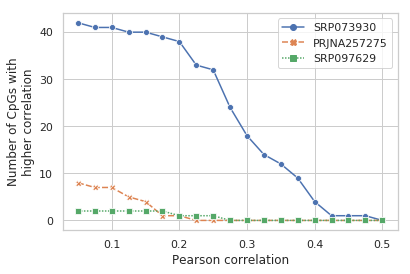

In [14]:
ax = sns.lineplot(data = count_gt.T,markers=True)
ax.set_xlabel('Pearson correlation')
ax.set_ylabel('Number of CpGs with\nhigher correlation')
plt.show()
plt.close()

There are more CpGs that have a stronger correlation in blood than in liver, but the Reizel dataset seems to show a higher skew. We can investigate these CpGs (now averaging into 30bp windows) and looking at Reizel only for liver (colored by week) blood is still colored by ageBin.

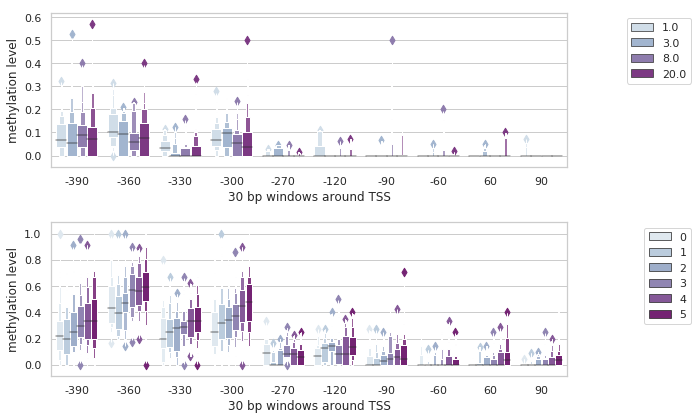

In [15]:
f,axes = plt.subplots(2,1,figsize=(10,6))
i = 0
for k,pltgrp in catplt[catplt['study']!='SRP097629'].groupby('tissue'):
    #print(k)
    if k == 'liver':
        ax = sns.boxenplot(x='cRound',y='value',hue='AgeWeek',data=pltgrp,palette='BuPu', ax = axes[i])
    else:
        ax = sns.boxenplot(x='cRound',y='value',hue='ageBin',data=pltgrp,palette='BuPu',ax = axes[i])
    ax.set_xlabel('30 bp windows around TSS')
    ax.set_ylabel('methylation level')
    i=i+1
    ax.legend(bbox_to_anchor=(1.25,1))
f.tight_layout()
plt.show()
plt.close()

Now just looking at Reizel and CpGs that are -390 away and blood. Each plot shows a CpG with the distance from the TSS on it where methylation is plotted against age in weeks 

In [16]:
catplt_use = catplt[(catplt['study']!='SRP097629') & (catplt['cRound']==-390)]

liver


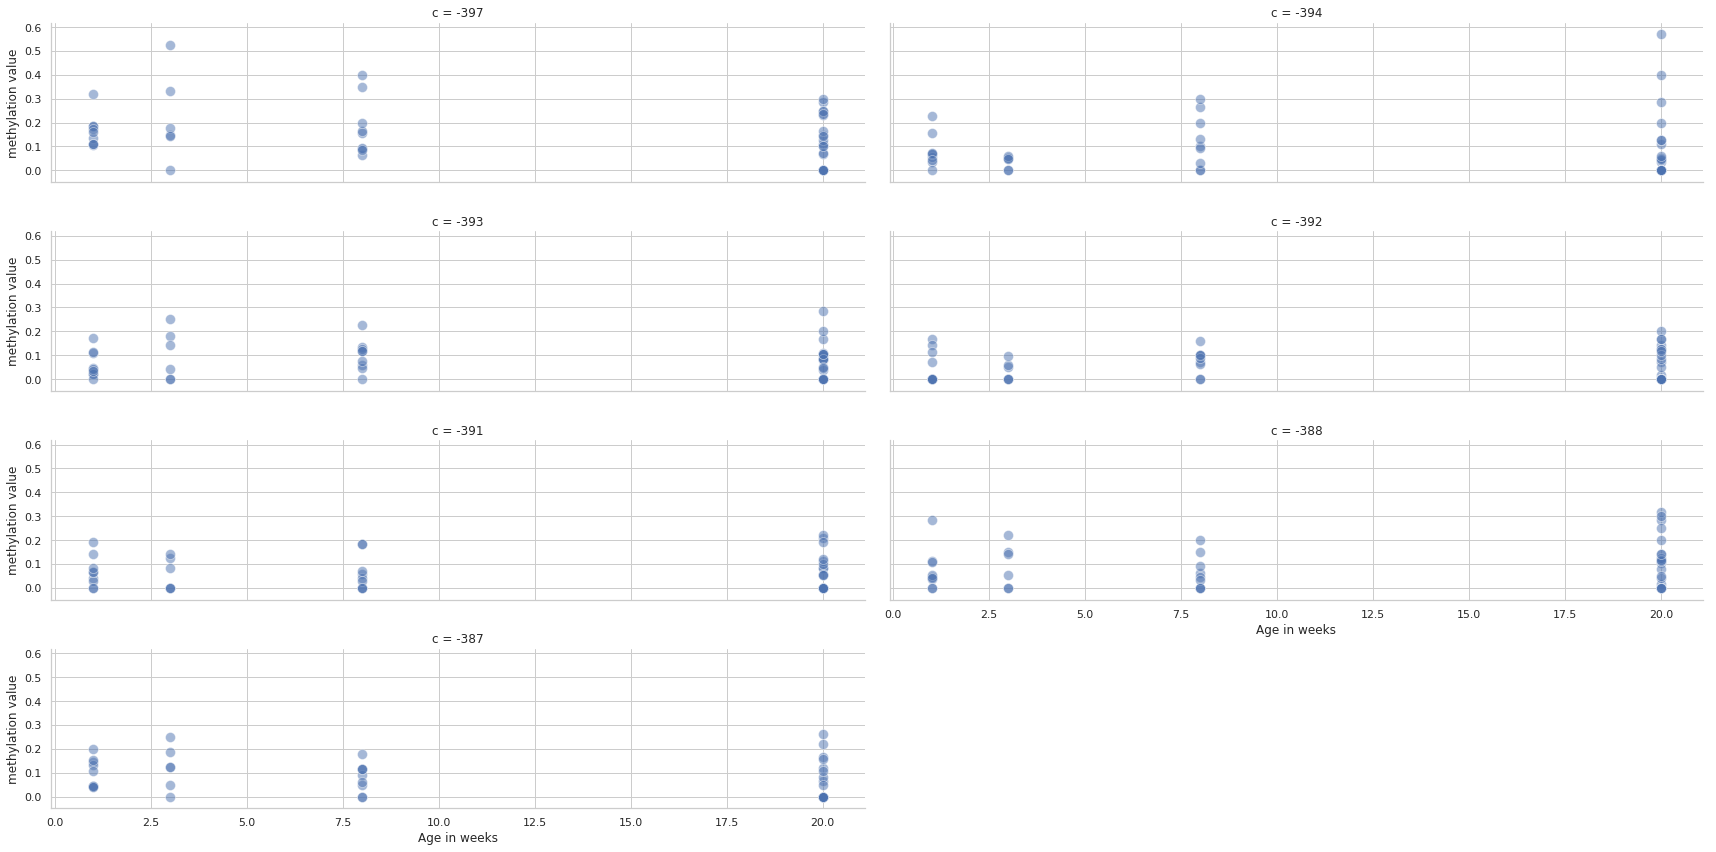

blood


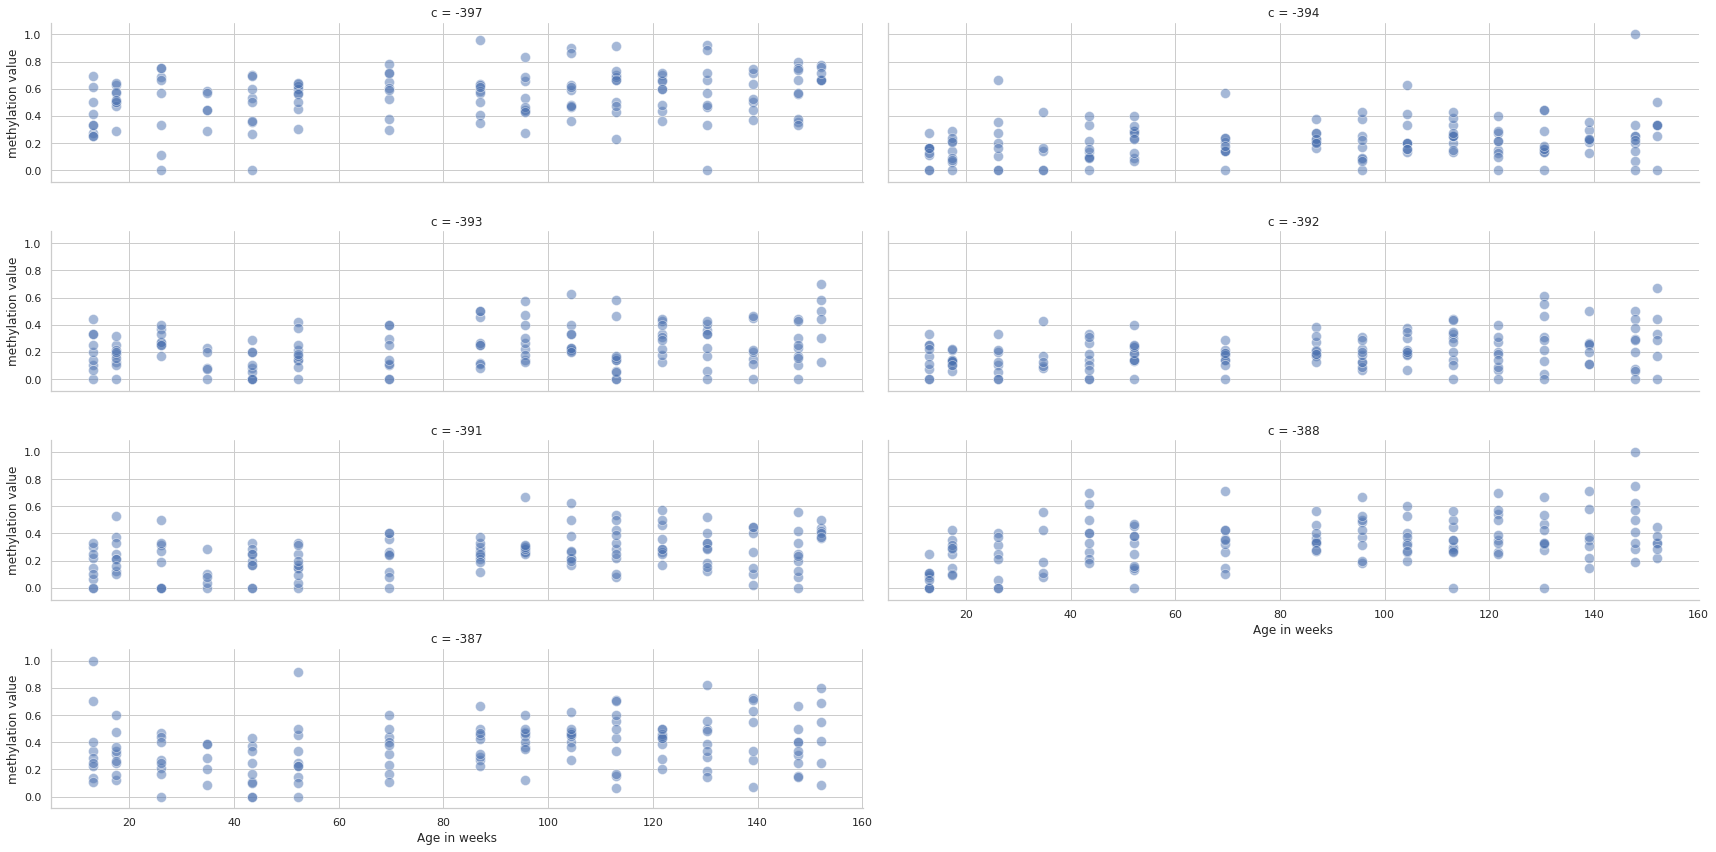

In [18]:
for k,pltgrp in catplt_use.groupby('study'):
    print(map_study_to_tissue[k])
    g = sns.relplot(x='AgeWeek',y='value',col='c',data=pltgrp,col_wrap=2, aspect = 4, height=3, s = 100,alpha = 0.5)
    g.set(xlabel='Age in weeks', ylabel='methylation value')
    plt.show()
    plt.close()

## Summary

Signal in liver is much weaker than blood. I am not sure how useful this is. <br>
<br>
There might be a signal at -390 CpG sites for liver. It might be that the liver is not old enough. However, the stubbs data does take them out to about 20-30 weeks, but it is possible that this data isn't quite complete enough because it's too low of samples. Either way blood looks the strongest.